In [25]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

In [26]:
def preprocess_data(features, labels=None):
    if labels is not None:
        features = features.join(labels)
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)
    features = features.interpolate(method="quadratic")

    features['week_sin'] = np.sin(2 * np.pi * features['weekofyear']/53.0)
    features['week_cos'] = np.cos(2 * np.pi * features['weekofyear']/53.0)
    features = features.drop('weekofyear', axis=1)

    if labels is not None:
        delta_y = features['total_cases'] - features['total_cases'].shift(1).fillna(0)
        return features.drop('total_cases', axis=1), delta_y
    else:
        return features

def get_data(features_path, labels_path=None):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = preprocess_data(sj_features, sj_labels)
        iq_f, iq_l = preprocess_data(iq_features, iq_labels)
        return sj_f, sj_l, iq_f, iq_l

    return preprocess_data(sj_features, None), preprocess_data(iq_features, None)


In [27]:
sj_X_data, sj_y_data, iq_X_data, iq_y_data = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv')

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [28]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_data, sj_y_data, test_size=0.3, shuffle=False)

iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_data, iq_y_data, test_size=0.3, shuffle=False)

'''sj_X_train = sj_X_data
sj_y_train = sj_y_data

iq_X_train = iq_X_data
iq_y_train = iq_y_data'''

'sj_X_train = sj_X_data\nsj_y_train = sj_y_data\n\niq_X_train = iq_X_data\niq_y_train = iq_y_data'

In [29]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,655.0,0.086158,0.096638,-0.290200,0.032292,0.082800,0.129210,0.446267
ndvi_nw,655.0,0.084960,0.106930,-0.567938,0.044733,0.085600,0.134550,0.437100
ndvi_se,655.0,0.170185,0.094370,-0.556810,0.140464,0.177643,0.212529,0.393129
ndvi_sw,655.0,0.163893,0.063279,-0.111362,0.129112,0.167943,0.203043,0.381420
precipitation_amt_mm,655.0,34.365767,41.398842,-15.492810,0.705000,21.530000,50.610000,287.550000
reanalysis_air_temp_k,655.0,299.020389,1.181711,295.938571,298.015714,299.215714,299.980714,301.255714
reanalysis_avg_temp_k,655.0,299.128194,1.159116,296.114286,298.160714,299.314286,300.053571,301.407143
reanalysis_dew_point_temp_k,655.0,295.064769,1.568129,289.642857,293.820714,295.447143,296.355714,297.467143
reanalysis_max_air_temp_k,655.0,301.255595,1.199172,298.200000,300.400000,301.400000,302.300000,303.900000
reanalysis_min_air_temp_k,655.0,297.200063,1.269514,292.600000,296.200000,297.500000,298.200000,299.500000


In [30]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,364.0,0.267057,0.081455,0.088616,0.204575,0.267829,0.323507,0.488400
ndvi_nw,364.0,0.233889,0.075983,0.035860,0.178186,0.226736,0.289986,0.428771
ndvi_se,364.0,0.251451,0.076860,0.029880,0.195130,0.250836,0.305611,0.473400
ndvi_sw,364.0,0.264058,0.083723,0.064183,0.206225,0.261300,0.321064,0.546017
precipitation_amt_mm,364.0,64.413590,34.986159,0.000000,39.452500,60.850000,86.507500,173.450000
reanalysis_air_temp_k,364.0,297.856586,1.193372,294.635714,297.062857,297.822857,298.588214,301.637143
reanalysis_avg_temp_k,364.0,299.129271,1.346382,294.892857,298.217857,299.121429,300.108929,302.928571
reanalysis_dew_point_temp_k,364.0,295.318981,1.478115,290.088571,294.344643,295.740000,296.457857,297.852857
reanalysis_max_air_temp_k,364.0,307.190040,2.456329,300.000000,305.200000,307.200000,308.900000,314.000000
reanalysis_min_air_temp_k,364.0,292.711199,1.692738,286.900000,291.800000,292.900000,294.000000,295.700000


In [31]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

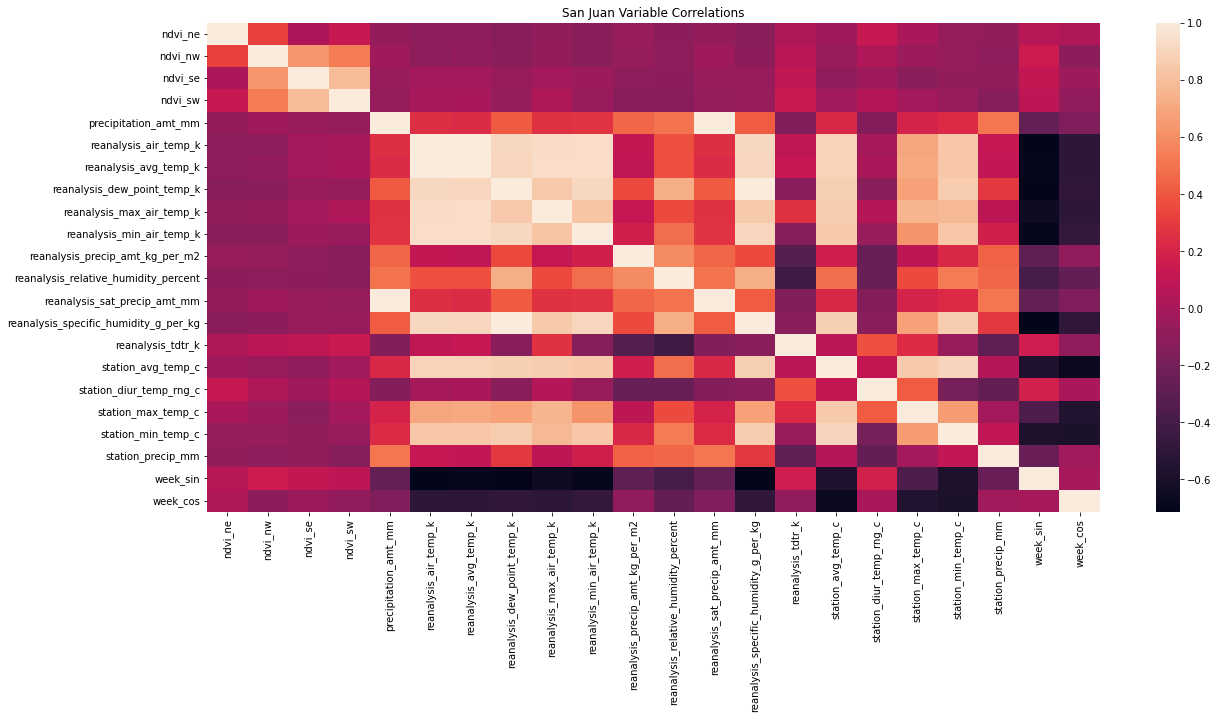

In [32]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [33]:
sj_rf = RandomForestRegressor(100, min_samples_leaf=5)
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

5.748521318506724
8.440837849877132


In [34]:
sj_rf.feature_importances_

array([0.03282076, 0.22138057, 0.10577049, 0.04035032, 0.01157409,
       0.02314897, 0.02114645, 0.09841701, 0.01545499, 0.02621658,
       0.03468185, 0.03423327, 0.01069815, 0.04745709, 0.02578018,
       0.06768847, 0.037395  , 0.01197853, 0.02788521, 0.03592625,
       0.03717902, 0.03281675])

<AxesSubplot:ylabel='cols'>

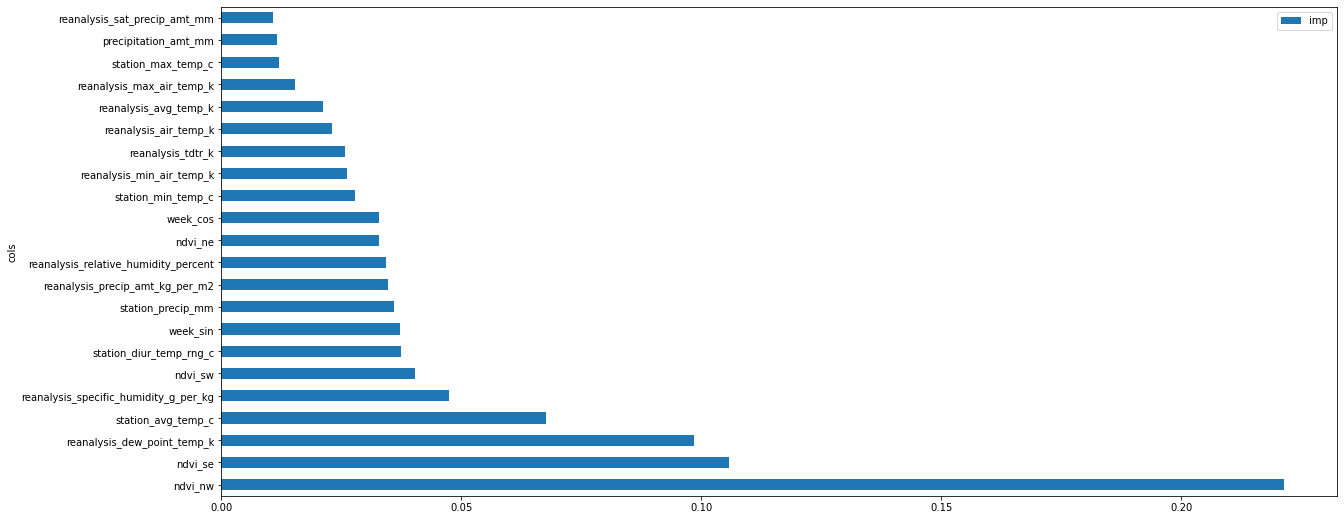

In [35]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [36]:
iq_rf = RandomForestRegressor(100, min_samples_leaf=5)
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

2.6330436825210723
4.891077519991413


In [37]:
iq_rf.feature_importances_

array([0.03046529, 0.02917765, 0.05099334, 0.05825587, 0.01492134,
       0.03694158, 0.02719689, 0.04777605, 0.03410852, 0.04347936,
       0.04435373, 0.02336076, 0.02232821, 0.07572259, 0.03048346,
       0.03914779, 0.02452497, 0.01722468, 0.09738651, 0.08082883,
       0.03831528, 0.1330073 ])

<AxesSubplot:ylabel='cols'>

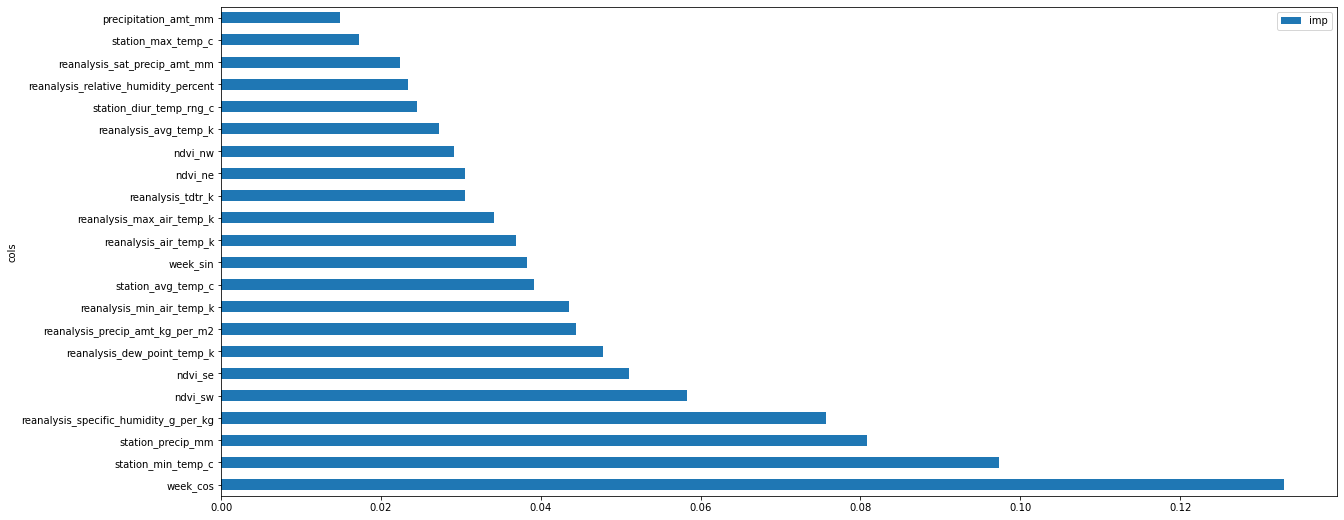

In [38]:
plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

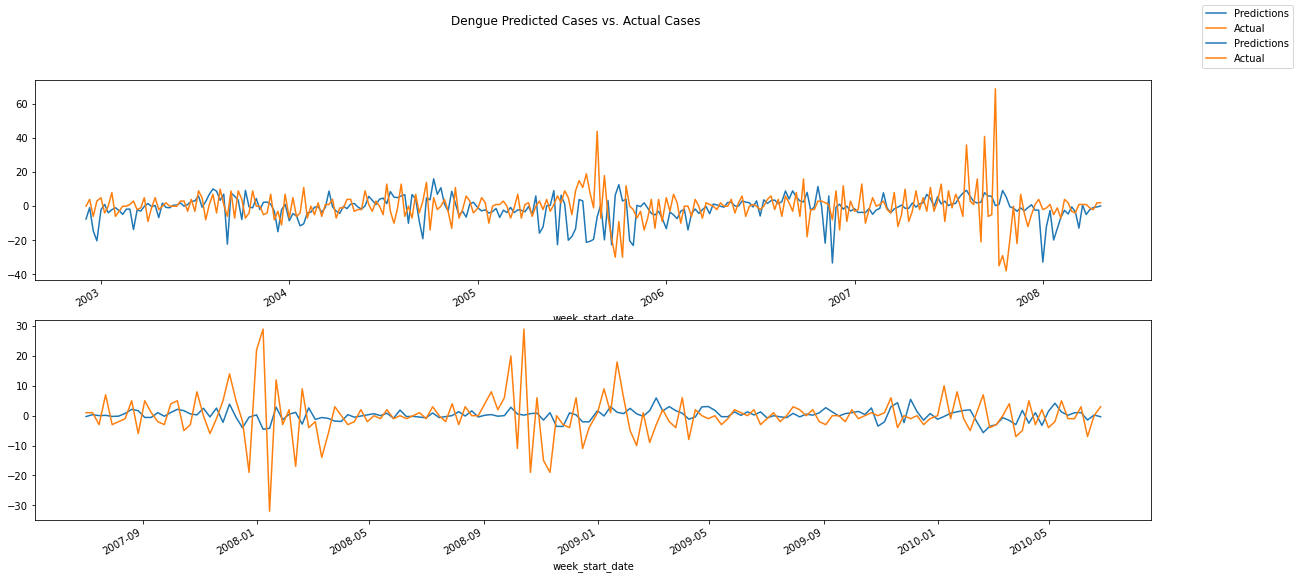

In [39]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [40]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [41]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv') 

In [42]:
sj_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,week_sin,week_cos
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,...,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0.845596,-0.533823
2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,...,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0.776524,-0.630088
2008-05-13,-0.001500,-0.031051,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,...,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,0.696551,-0.717507
2008-05-20,0.052862,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,...,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,0.606800,-0.794854
2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,...,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,0.508531,-0.861044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,...,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5,0.999561,0.029633
2013-04-02,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,...,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6,0.996050,-0.088796
2013-04-09,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,...,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4,0.978556,-0.205979


In [43]:
iq_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,week_sin,week_cos
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,...,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2,0.059241,-0.998244
2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,...,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9,-0.059241,-0.998244
2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,...,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6,-0.176890,-0.984231
2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,...,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8,-0.292057,-0.956401
2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,...,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0,-0.403123,-0.915146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,...,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0,0.508531,-0.861044
2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,...,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0,0.403123,-0.915146
2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,...,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2,0.292057,-0.956401


In [44]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [45]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 8.440837849877132
iq 4.891077519991413


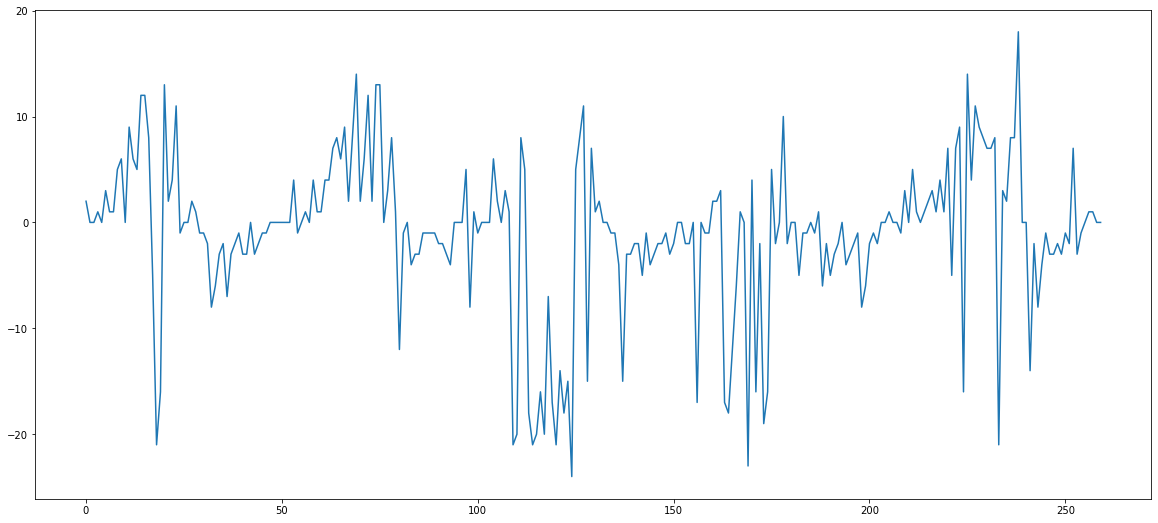

In [46]:
plt.plot(sj_predictions)

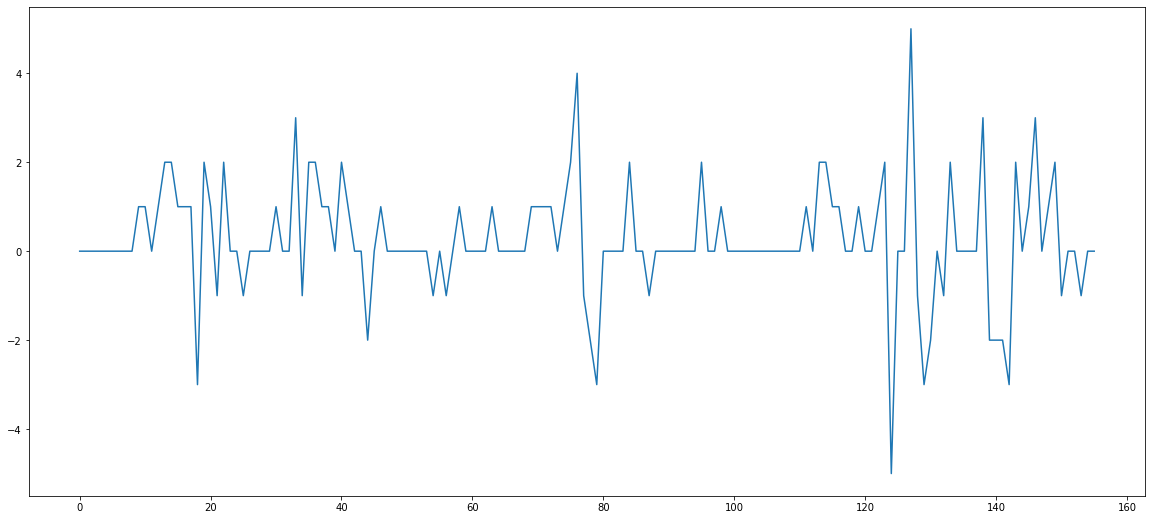

In [47]:
plt.plot(iq_predictions)

In [48]:
joblib.dump(sj_rf,'sj_rf.pkl')
joblib.dump(iq_rf, 'iq_rf.pkl')

['iq_rf.pkl']